<a href="https://colab.research.google.com/github/itsmeyessir/CCMACLRL_EXERCISES_COM221ML/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence if a hate speech or not
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [215]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

## Training Set

Use this to train your model

In [216]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

In [217]:
df_train.head()

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


<ipython-input-218-7de7569ace88>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count =pd.value_counts(df_train["label"], sort= True)


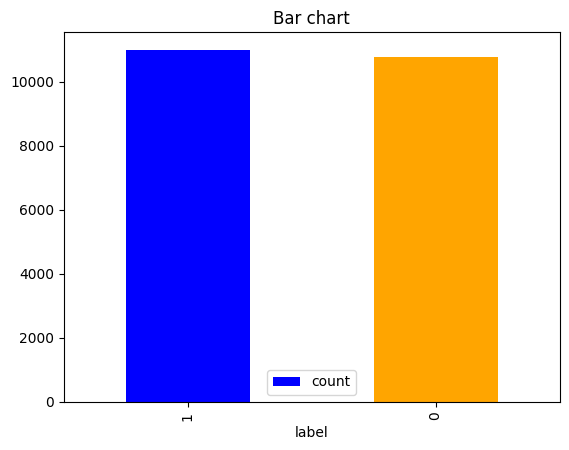

In [218]:
import matplotlib.pyplot as plt
count =pd.value_counts(df_train["label"], sort= True)
count.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.legend(loc='best')
plt.show()

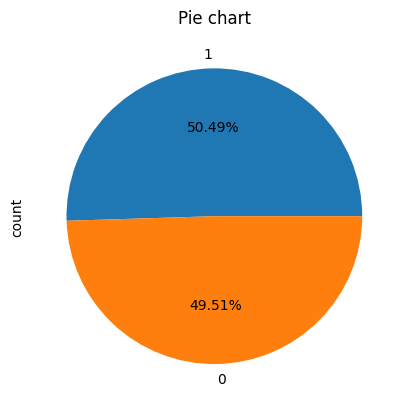

In [219]:
count.plot(kind = 'pie',autopct='%1.2f%%') # 1.2 is the decimal points for 2 places
plt.title('Pie chart')
plt.show()

In [220]:
#check for missing data
print("Missing data in each column:\n" + str(df_train.isnull().sum()))

Missing data in each column:
text     0
label    0
dtype: int64


In [221]:
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


<ipython-input-222-7a02c2e581c5>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df_train['label'], palette = 'rocket')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


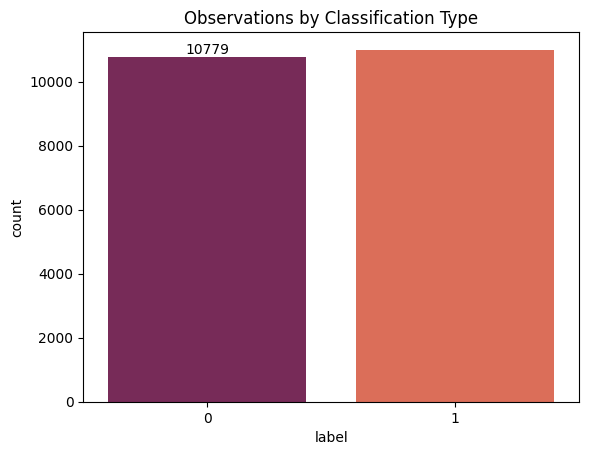

In [222]:
# Explore distribution of dataset

# count plot on single categorical variable
ax = sns.countplot(x = df_train['label'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

In [223]:
tagalog = ["akin","aking","ako","alin","am","amin","aming","ang","ano","anumang","apat","at","atin","ating","ay","bababa","bago","bakit","bawat",
           "bilang","dahil","dalawa","dapat","din","dito","doon","gagawin","gayunman","ginagawa","ginawa","ginawang","gumawa","gusto","habang",
           "hanggang","hindi","huwag","iba","ibaba","ibabaw","ibig","ikaw","ilagay","ilalim","ilan","inyong","isa","isang","itaas","ito","iyo",
           "iyon","iyong","ka","kahit","kailangan","kailanman","kami","kanila","kanilang","kanino","kanya","kanyang","kapag","kapwa","karamihan",
           "katiyakan","katulad","kaya","kaysa","ko","kong","kulang","kumuha","kung","laban","lahat","lamang","likod","lima","maaari","maaaring",
           "maging","mahusay","makita","marami","marapat","masyado","may","mayroon","mga","minsan","mismo","mula","muli","na","nabanggit","naging",
           "nagkaroon","nais","nakita","namin","napaka","narito","nasaan","ng","ngayon","ni","nila","nilang","nito","niya","niyang","noon","o","pa",
           "paano","pababa","paggawa","pagitan","pagkakaroon","pagkatapos","palabas","pamamagitan","panahon","pangalawa","para","paraan","pareho",
           "pataas","pero","pumunta","pumupunta","sa","saan","sabi","sabihin","sarili","sila","sino","siya","tatlo","tayo","tulad","tungkol","una","walang"]

In [224]:
def text_clean(text, method, rm_stop):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase
    text = re.sub(r"\d+","",text)   #remove digits and currencies
    text = re.sub(r'[\$\d+\d+\$]', "", text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks

    #remove stop words
    if rm_stop == True:
        filtered_tokens = [word for word in word_tokenize(text) if not word in set(tagalog + stopwords.words('english'))]
        text = " ".join(filtered_tokens)

    #lemmatization: typically preferred over stemming
    if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)

    #stemming
    if method == 'S':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in word_tokenize(text)]
        return " ".join(stem_tokens)

    return text

In [225]:
text = df_train.text[0]
print(text)

Presidential candidate Mar Roxas implies that the govt should not be liable re: Laglag Bala. Laglag Bayag na ata ito


In [226]:
text = text_clean(text, 'L', True) # Added the method and rm_stop arguments
print(text)

presidential candidate mar roxas implies govt liable laglag bala laglag bayag ata


In [232]:
X_train = df_train["text"].values
Y_train = df_train["label"].values

In [233]:
#preprocessed data: Lemm + stopword removal
preprocessed_text_1 = [text_clean(text, 'L', True) for text in X_train]

#preprocessed data: Lemm + no stopword removal
preprocessed_text_2 = [text_clean(text, 'L', False) for text in X_train]

In [234]:
#preprocessed data: Stem + stopword removal
preprocessed_text_3 = [text_clean(text, 'S', True) for text in X_train]

#preprocessed data: Stem + no stopword removal
preprocessed_text_4 = [text_clean(text, 'S', False) for text in X_train]

In [235]:
df_train['cleaned_text'] = df_train['text'].apply(lambda x: text_clean(x, 'L', True))

In [261]:
df_train.head()

,text,label,cleaned_text
0,Presidential candidate Mar Roxas implies that ...,1,presidential candidate mar roxas implies govt ...
1,Parang may mali na sumunod ang patalastas ng N...,1,parang mali sumunod patalastas nescaf coffee b...
2,Bet ko. Pula Ang Kulay Ng Posas,1,bet pula kulay posas
3,[USERNAME] kakampink,0,username kakampink
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1,parang tahimik pink doc willie ong reaction paper


## Validation Set

Use this set to evaluate your model

In [236]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

In [237]:
df_validation['cleaned_text'] = df_validation['text'].apply(lambda x: text_clean(x, 'L', True))

In [238]:
X_test = df_test["text"].values
Y_test = df_test["label"].values

In [240]:
def transform_model_data_w_tfidf_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset
    tfidf = TfidfVectorizer()
    vectorized_data = tfidf.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions, model

In [242]:
#vectorize, model, and evaluate model using TfidfVectorizer

#Lemm + stopword removal
print("Lemm + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

#Lemm + no stopword removal
print("\nLemm + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

#Stem + stopword removal
print("\nStem + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test)

#Stem + no stopword removal
print("\nStem + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Lemm + stopword removal + TfidfVectorizer
Accuracy: 81.39 %
Balanced accuracy: 81.41 %
Precision: 78.92 %

Lemm + no stopword removal + TfidfVectorizer
Accuracy: 82.06 %
Balanced accuracy: 82.08 %
Precision: 79.6 %

Stem + stopword removal + TfidfVectorizer
Accuracy: 78.01 %
Balanced accuracy: 78.0 %
Precision: 78.8 %

Stem + no stopword removal + TfidfVectorizer
Accuracy: 79.57 %
Balanced accuracy: 79.57 %
Precision: 80.29 %


(array([0, 0, 1, ..., 1, 0, 1]), MultinomialNB(alpha=0.1))

In [243]:
predictions, model = transform_model_data_w_tfidf_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

Accuracy: 82.06 %
Balanced accuracy: 82.08 %
Precision: 79.6 %


## Test Set

Use this set to test your model

In [244]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

In [245]:
df_test['cleaned_text'] = df_test['text'].apply(lambda x: text_clean(x, 'L', True))

In [246]:
df_test.head()

,text,label,cleaned_text
0,Binay: Patuloy ang kahirapan dahil sa maling p...,0,binay patuloy kahirapan maling pamamahala user...
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT...,0,gobyernong tapat welcome baguo kulay rosa buka...
2,wait so ur telling me Let Leni Lead mo pero NY...,1,wait ur telling let leni lead mo nyong uyab bb...
3,[USERNAME]wish this is just a nightmare that ...,0,usernamewish nightmare could end failed let le...
4,doc willie ong and isko sabunutan po,0,doc willie ong isko sabunutan po


In [260]:
new_text = pd.Series("gago")
tfidf.fit(preprocessed_text_2)

new_text_transform = tfidf.transform(new_text)
prediction = model.predict(new_text_transform)
if prediction == 1:
    print("hate speech")
else:
    print("non-hate speech")

hate speech
